# Récupération des données à traiter

In [1]:
from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np

from joblib import dump, load
import pickle
import os 
import shap
import importlib
import lime
from lime.lime_tabular import LimeTabularExplainer

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
def modelAlreadyTrain(filename):
    return os.path.isfile('../models/' + filename)

def savePickleModel(model, filename):
    with open('../models/' + filename, 'wb') as f:
        pickle.dump(model, f)
        f.close()

def loadPickleModel(filename):
    with open('../models/' + filename, 'rb') as f:
        model = pickle.load(f)
        f.close()
        return model

In [3]:
df=pd.read_csv('../Data/processed/Co2_final.csv')

In [4]:
X = df.drop(columns=['Ewltp (g/km)','ID'])
y = df['Ewltp (g/km)']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [6]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [8]:
savePickleModel(lr, 'mlk-lr_modele.pkl')

In [7]:
from RegressorModel import RegressorModel
Model = RegressorModel('LinearModel', 
                          lr, 
                          X_train, 
                          X_test, 
                          y_train, 
                          y_test, 
                          X.columns)

Model.predictModel()
Model.calcScore()
Model.displayScore()

RMSE Jeux d entrainement : 2.548050063155176
RMSE Jeux de test : 2.5085814646734503
Score du modèle train (R²) 0.9970641009677415
Score du modèle test (R²) 0.9971469481366201


In [10]:
Model.writeResults()

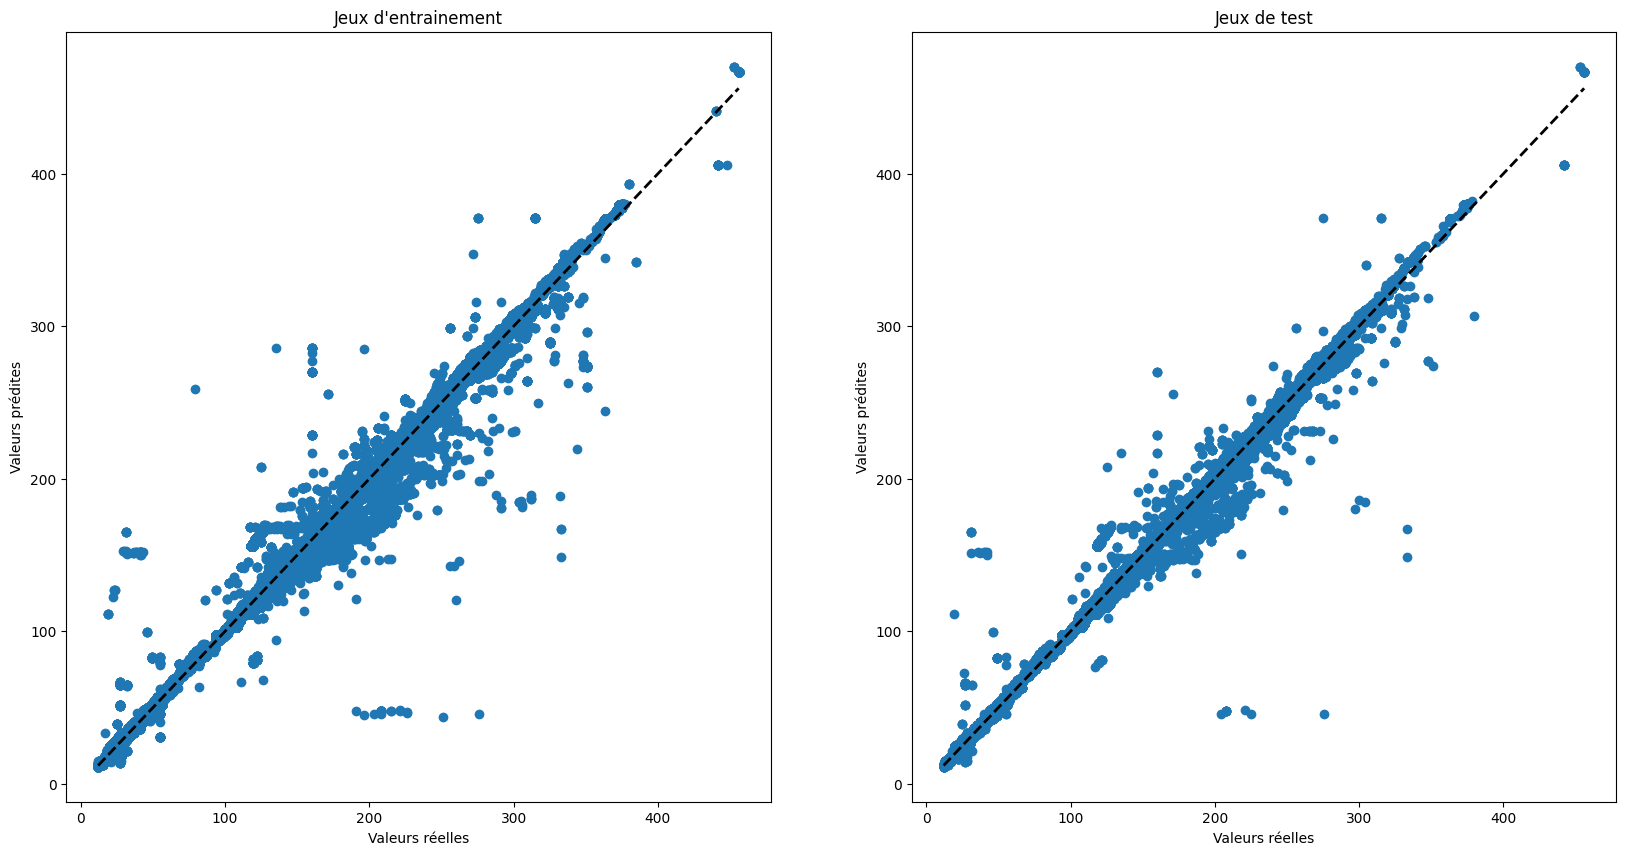

In [11]:
Model.displayGraphResultVsReel()

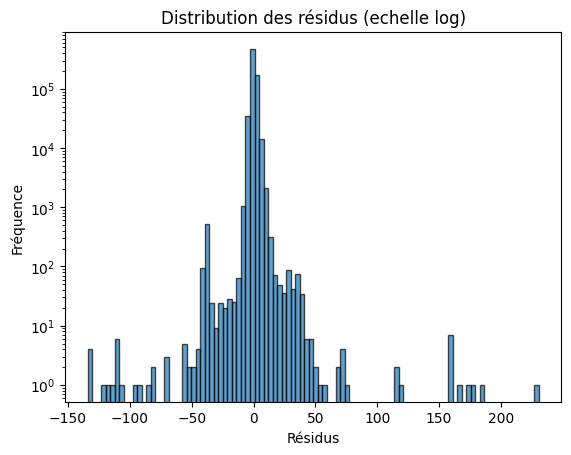

In [8]:
Model.displayDistributionOfResidue(True)

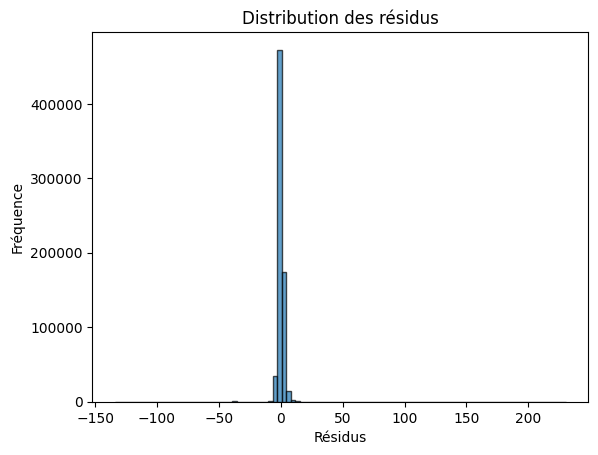

In [9]:
Model.displayDistributionOfResidue(False)

In [13]:
coeffs = list(lr.coef_)
coeffs.insert(0, lr.intercept_)
feats = list(X.columns)
feats.insert(0, 'intercept')
pd.DataFrame({'valeur estimée': coeffs}, index=feats)

,valeur estimée
intercept,34.356615
Mp,-2.287851
T,-3.765167
m (kg),0.005046
W (mm),0.002078
At1 (mm),-0.010334
ec (cm3),-0.001214
ep (KW),-0.012009
Fuel consumption,23.464972
Country_FR,-0.192176


In [14]:
f_stat, p_value = f_regression(X_train, y_train)
print('F-statistique :', f_stat, '\np-value :', p_value)

F-statistique : [5.57206864e+04 1.87571462e+04 9.83357578e+02 1.15130520e+05
 5.88320277e+04 3.01189843e+05 5.37977490e+05 4.14846505e+07
 4.12377623e+04 3.35472127e+04 1.05820527e+02 7.13317605e+00
 6.84999737e+04 9.09483132e+01 1.51909807e+03 2.28706076e+02
 3.10914332e+05 3.68246112e+06 7.88226894e+00 3.48667817e+04
 7.33204494e+05 4.19808314e+06] 
p-value : [0.00000000e+000 0.00000000e+000 8.11588302e-216 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 8.08073195e-025 7.56710119e-003
 0.00000000e+000 1.47585875e-021 0.00000000e+000 1.14703271e-051
 0.00000000e+000 0.00000000e+000 4.99221537e-003 0.00000000e+000
 0.00000000e+000 0.00000000e+000]


In [15]:
resultats = pd.DataFrame({
    'Caractéristiques': feats,
    'Coefficient': coeffs,
    'F-statistique': [None] + list(f_stat),
    'P-value': [None] + list(p_value)
})

print(resultats)

      Caractéristiques  Coefficient  F-statistique        P-value
0            intercept    34.356615            NaN            NaN
1                   Mp    -2.287851   5.572069e+04   0.000000e+00
2                    T    -3.765167   1.875715e+04   0.000000e+00
3               m (kg)     0.005046   9.833576e+02  8.115883e-216
4               W (mm)     0.002078   1.151305e+05   0.000000e+00
5             At1 (mm)    -0.010334   5.883203e+04   0.000000e+00
6             ec (cm3)    -0.001214   3.011898e+05   0.000000e+00
7              ep (KW)    -0.012009   5.379775e+05   0.000000e+00
8    Fuel consumption     23.464972   4.148465e+07   0.000000e+00
9           Country_FR    -0.192176   4.123776e+04   0.000000e+00
10              Ct_M1G     0.963016   3.354721e+04   0.000000e+00
11               Ct_N1     7.609766   1.058205e+02   8.080732e-25
12              Ct_N1G     2.192902   7.133176e+00   7.567101e-03
13  Ft_diesel/electric    -8.247910   6.849997e+04   0.000000e+00
14        

In [16]:
feature_importances = resultats.copy()
feature_importances['Abs_Coefficient'] = resultats['Coefficient'].apply(abs)
feature_importances = feature_importances.sort_values(by='Abs_Coefficient', ascending=True).drop(columns='Abs_Coefficient')
print(feature_importances)

      Caractéristiques  Coefficient  F-statistique        P-value
6             ec (cm3)    -0.001214   3.011898e+05   0.000000e+00
4               W (mm)     0.002078   1.151305e+05   0.000000e+00
3               m (kg)     0.005046   9.833576e+02  8.115883e-216
5             At1 (mm)    -0.010334   5.883203e+04   0.000000e+00
7              ep (KW)    -0.012009   5.379775e+05   0.000000e+00
9           Country_FR    -0.192176   4.123776e+04   0.000000e+00
10              Ct_M1G     0.963016   3.354721e+04   0.000000e+00
12              Ct_N1G     2.192902   7.133176e+00   7.567101e-03
1                   Mp    -2.287851   5.572069e+04   0.000000e+00
2                    T    -3.765167   1.875715e+04   0.000000e+00
19                Fm_F    -6.367801   7.882269e+00   4.992215e-03
11               Ct_N1     7.609766   1.058205e+02   8.080732e-25
13  Ft_diesel/electric    -8.247910   6.849997e+04   0.000000e+00
18  Ft_petrol/electric   -11.032650   3.682461e+06   0.000000e+00
20        

In [17]:
print("R² score sur l\'ensemble d\'entrainement:", lr.score(X_train, y_train))

R² score sur l'ensemble d'entrainement: 0.9970641009677415


In [18]:
print("R² score sur l\'ensemble de test:", lr.score(X_test, y_test))

R² score sur l'ensemble de test: 0.9971469481366201


In [19]:
print("Scores de validation croisée (R²):", cross_val_score(lr, X_train, y_train, cv=5, scoring='r2'))

Scores de validation croisée (R²): [0.99716723 0.99695355 0.99705454 0.99702769 0.99711535]


In [20]:
print("Moyenne des scores de validation croisée (R²):", cross_val_score(lr, X_train, y_train, cv=5, scoring='r2').mean())
print("Écart type des scores de validation croisée (R²):", cross_val_score(lr, X_train, y_train, cv=5, scoring='r2').std())

Moyenne des scores de validation croisée (R²): 0.9970636723557316
Écart type des scores de validation croisée (R²): 7.334713925215157e-05


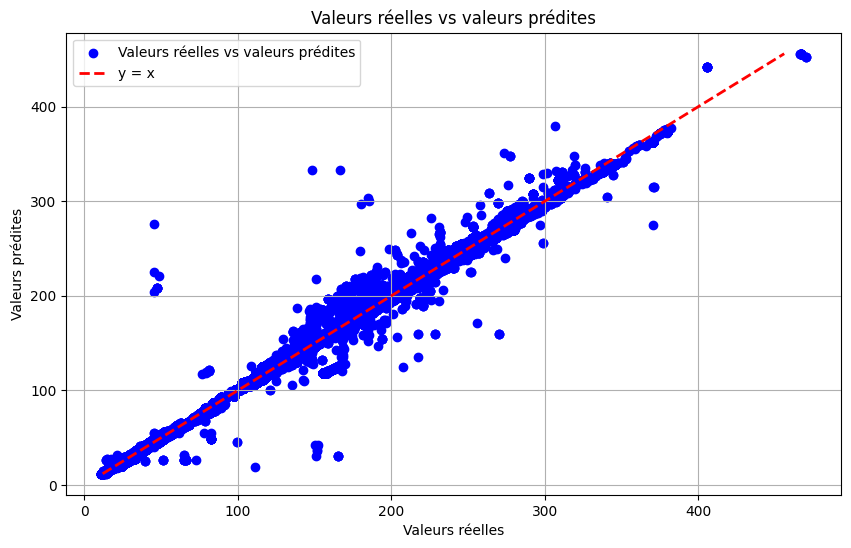

In [21]:
pred_test = lr.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(pred_test, y_test, color='blue', label='Valeurs réelles vs valeurs prédites')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--', label='y = x')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs réelles vs valeurs prédites')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
pred_train = lr.predict(X_train)
residus = y_train - pred_train
print('Résidus prédits sur l\'ensemble d\'entrainement',residus.describe())

Résidus prédits sur l'ensemble d'entrainement count    2.799028e+06
mean     1.197800e-13
std      2.548051e+00
min     -1.796518e+02
25%     -9.558130e-01
50%     -1.147372e-02
75%      9.150610e-01
max      2.302526e+02
Name: Ewltp (g/km), dtype: float64


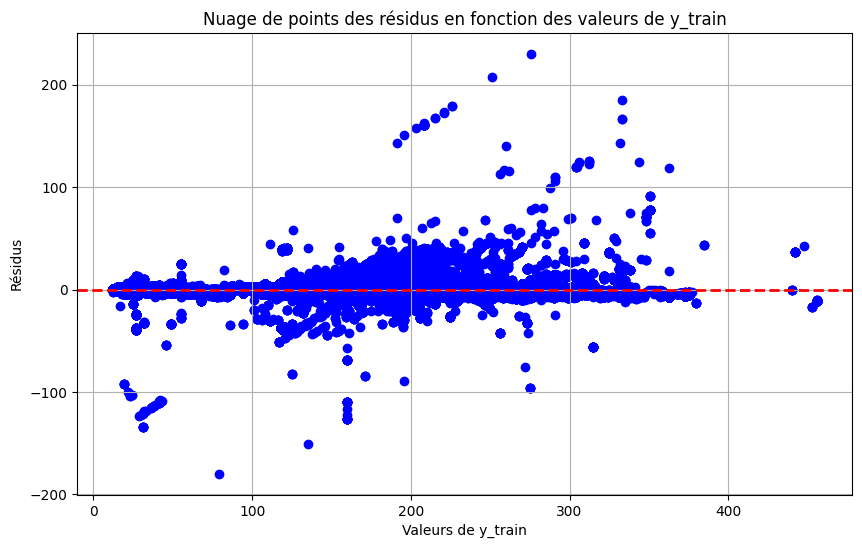

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, residus, color='blue')
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.xlabel('Valeurs de y_train')
plt.ylabel('Résidus')
plt.title('Nuage de points des résidus en fonction des valeurs de y_train')
plt.grid(True)
plt.show()

In [24]:
print("rmse train :", np.sqrt(mean_squared_error(y_train, pred_train)))
print('rmse test :', np.sqrt(mean_squared_error(y_test, pred_test)))

rmse train : 2.548050063155176
rmse test : 2.5085814646734503


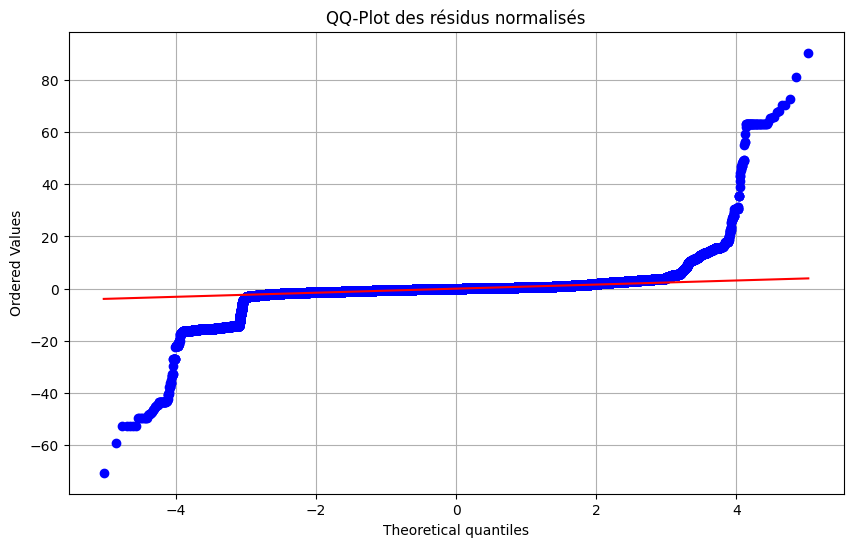

In [25]:
# Centrer et réduire les résidus
residus_mean = np.mean(residus)
residus_std = np.std(residus)
residus_norm = (residus - residus_mean) / residus_std

# Afficher le QQ-Plot des résidus normalisés
plt.figure(figsize=(10, 6))
stats.probplot(residus_norm, dist="norm", plot=plt)
plt.title('QQ-Plot des résidus normalisés')
plt.grid(True)
plt.show()

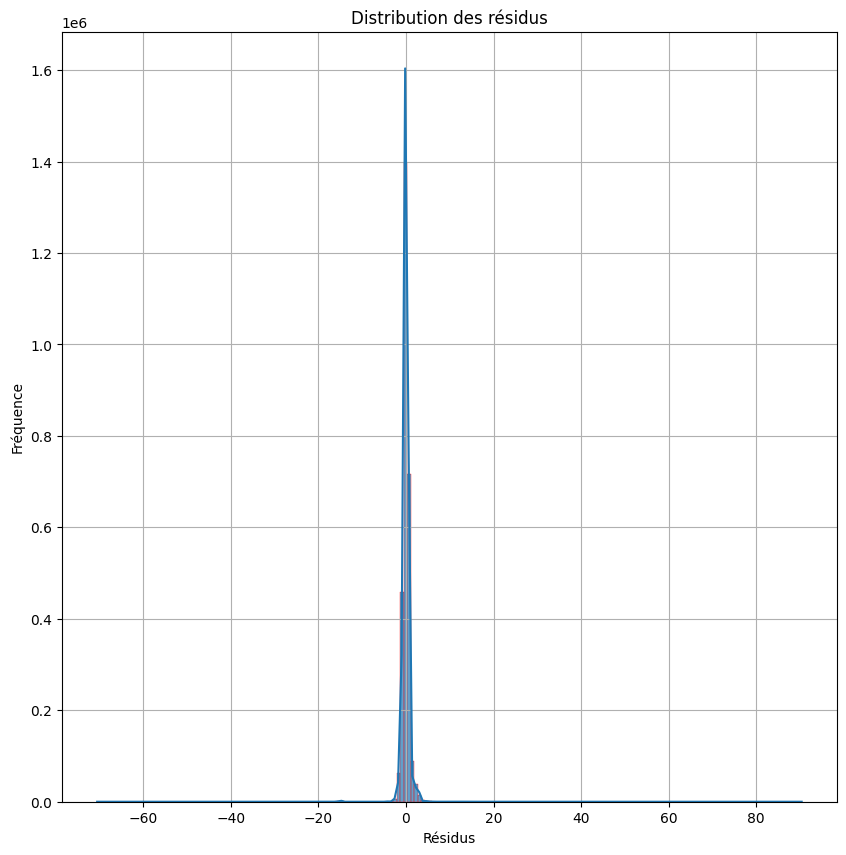

In [26]:
plt.figure(figsize=(10, 10))
sns.histplot(residus_norm, bins=200, edgecolor='red', kde=True, alpha=0.7)

plt.title("Distribution des résidus")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

## Interpretabilité du modèle

## Interprétabilité Locale

### Local Interpretable Model-agnostic Explanations (LIME)

In [58]:
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns.tolist(),
                                 class_names=['Ewltp (g/km)'],
                                 mode='regression')

In [59]:
i = X_test.iloc[0].values

pred_test = lr.predict([i])

exp = explainer.explain_instance(i, lambda x: lr.predict(x))

exp.show_in_notebook(show_table=True)

c:\Users\mlska\TEMPO\avr24_cds_co2\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\mlska\TEMPO\avr24_cds_co2\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


La difference de couleur nous montre tout d'abord les features qui contribuent à augmenter la valeur prédite (en orange) et celles qui au contraire contribuent à la reduire (en bleu).

On voit la valeur exacte de chaque feature de l'instance dans le tableau de droite, mais c'est surtout le graphique du milieu qui nous apprend le plus sur la contribution de chaque feature à la prédiction. par exemple, le fait que la valeur de Fuel consumption (11.80) soit supérieure à 6.30 semble justifier sa contribution positive avec une importance de 82.34.

## Interpretabilité globale du modèle

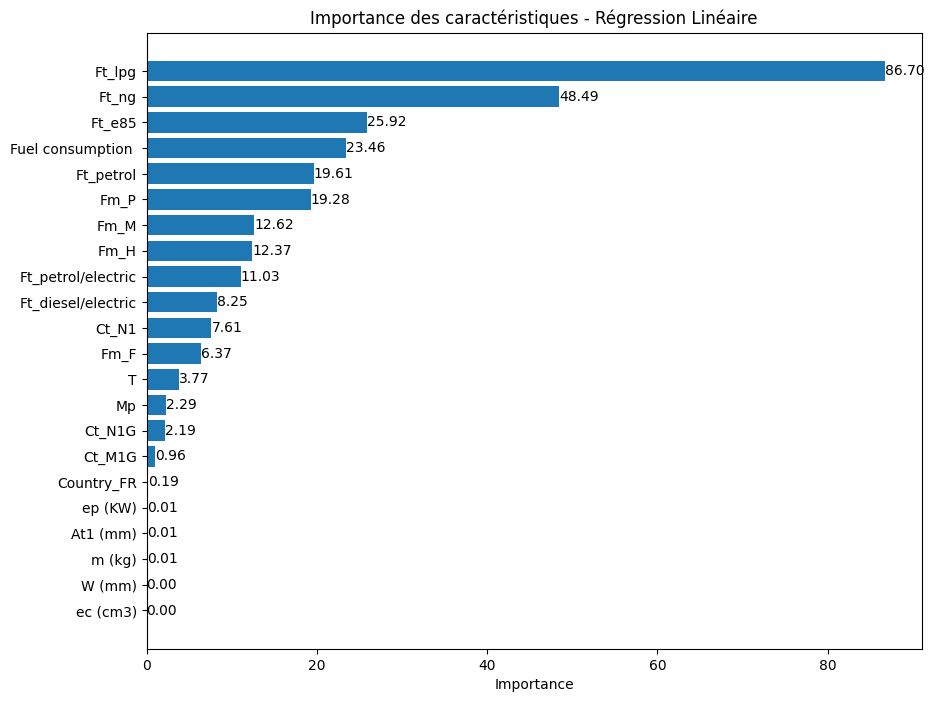

In [61]:
importance = np.abs(lr.coef_)

sorted_indices = np.argsort(importance)

sorted_importance = importance[sorted_indices]
sorted_features = X_train.columns[sorted_indices]

plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
plt.yticks(range(len(sorted_importance)), sorted_features)
plt.xlabel('Importance')
plt.title('Importance des caractéristiques - Régression Linéaire')

for bar, value in zip(bars, sorted_importance):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center')

plt.show()

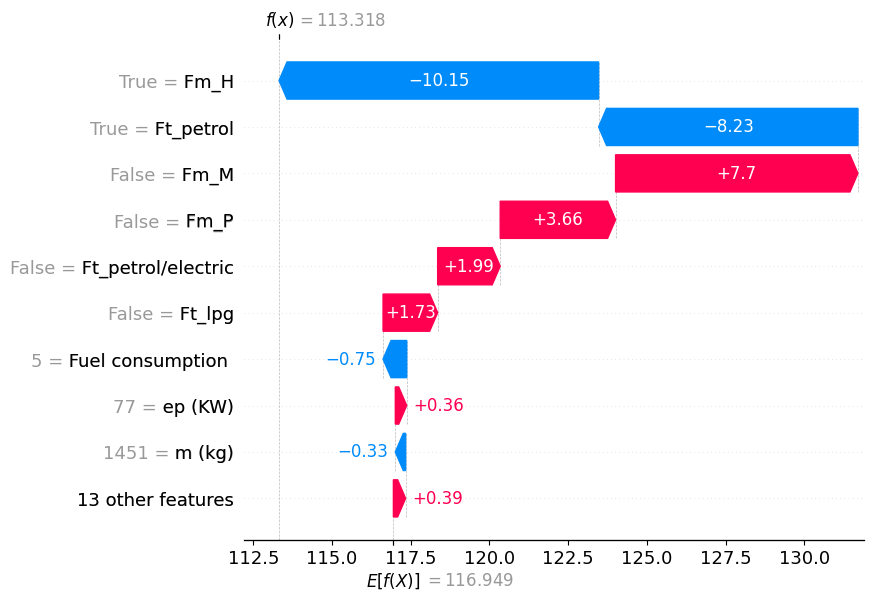

In [65]:
explainer = shap.LinearExplainer(lr, X_train)
shap_values = explainer.shap_values(X_test)
shap.initjs() 
shap.waterfall_plot(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_test.iloc[0]))
plt.show()


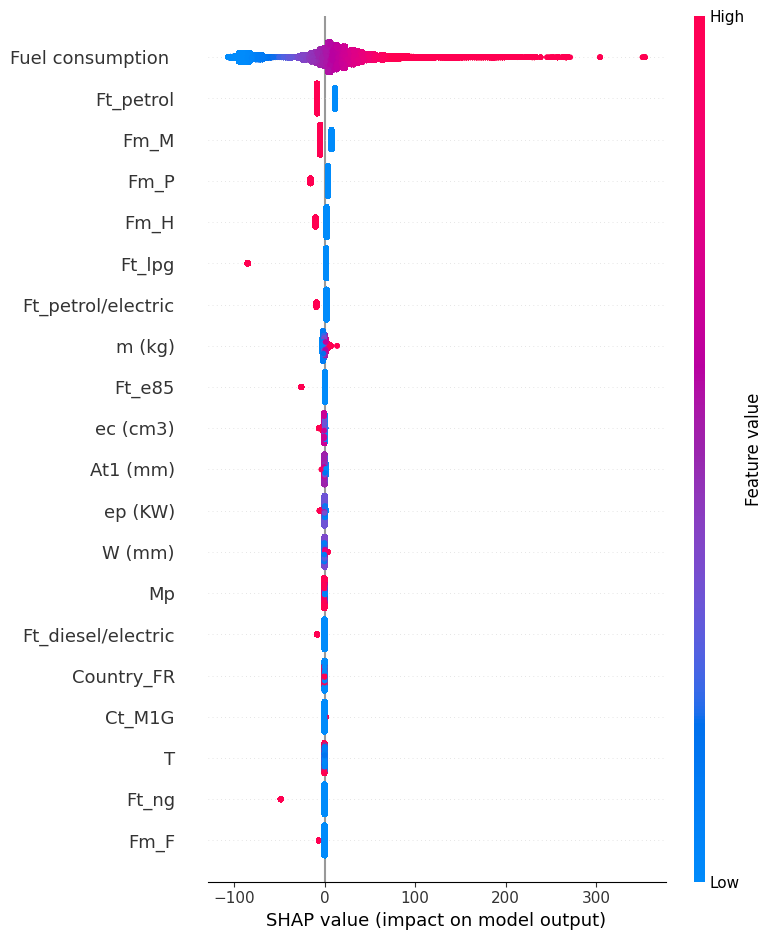

In [63]:
shap_values = np.array(shap_values, dtype=float)
shap.summary_plot(shap_values, X_test, plot_type="dot")